## 1. Load pdf

In [12]:
from langchain_community.document_loaders import PyPDFLoader



In [13]:
file_path = "./dataset/data_pdf.pdf"
loader = PyPDFLoader(file_path)

In [14]:
docs= loader.load()
docs[1]

Document(metadata={'producer': 'Adobe PDF Library 10.0.1', 'creator': 'PyPDF', 'creationdate': '2019-09-05T17:40:31+05:30', 'moddate': '2019-09-06T18:51:55+05:30', 'source': './dataset/data_pdf.pdf', 'total_pages': 199, 'page': 1, 'page_label': 'i'}, page_content='The IT Support Handbook\nA How-To Guide to Providing Effective \nHelp and Support to IT Users\nMike\xa0Halsey')

In [15]:
import pprint

pprint.pp(docs[1].metadata)

{'producer': 'Adobe PDF Library 10.0.1',
 'creator': 'PyPDF',
 'creationdate': '2019-09-05T17:40:31+05:30',
 'moddate': '2019-09-06T18:51:55+05:30',
 'source': './dataset/data_pdf.pdf',
 'total_pages': 199,
 'page': 1,
 'page_label': 'i'}


## 2. Load pages data

### 2.1 Extract text page par page

In [16]:
pages=[]
for doc in loader.lazy_load():
    pages.append(doc)
    print(doc.page_content[:100])
len(pages)


The IT Support 
Handbook
A How-To Guide to Providing Effective  
Help and Support to IT Users
—
Mike
The IT Support Handbook
A How-To Guide to Providing Effective 
Help and Support to IT Users
Mike Hal
The IT Support Handbook
ISBN-13 (pbk): 978-1-4842-5132-4   ISBN-13 (electronic): 978-1-4842-5133-1
h
For my father, James Halsey, who taught me the value of hard work 
and dedication, and who first int
v
Part I:  IT Support Fundamentals �����������������������������������������������������������������
vi
Chapter 3: Understanding Your Users: How Much Do They Know? ������������������������23
How to Com
vii
Take the User with You on the Journey ����������������������������������������������������������
viii
Chapter 8: The Human Factor �������������������������������������������������������������������
ix
Part IV:  Documentation and Reporting �������������������������������������������������������103

x
Chapter 14: Harnessing System and Error Reporting in Windows �����������������������133
R

199

In [17]:
print(pprint.pp(pages[12].metadata))

{'producer': 'Adobe PDF Library 10.0.1',
 'creator': 'PyPDF',
 'creationdate': '2019-09-05T17:40:31+05:30',
 'moddate': '2019-09-06T18:51:55+05:30',
 'source': './dataset/data_pdf.pdf',
 'total_pages': 199,
 'page': 12,
 'page_label': 'xv'}
None


### 2.2 Shunking (lang text -> small text)

**Recursive Character Splitting**

In [23]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Charger le PDF (page par page)
loader = PyPDFLoader("./dataset/data_pdf.pdf")
documents = loader.load()  
# chaque élément = 1 page, avec metadata {"page": x, "source": ...}

# 2. Définir le découpeur
splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=30,
    separators=["\n\n", "\n", ".", " "]
)

# 3. Découper en chunks en conservant les métadonnées
chunks = splitter.split_documents(documents)

# Exemple d'affichage
for c in chunks[:3]:
    print(f"PAGE: {c.metadata['page']} | TEXTE: {c.page_content}\n")


PAGE: 0 | TEXTE: The IT Support 
Handbook
A How-To Guide to Providing Effective  
Help and Support to IT Users
—
Mike Halsey

PAGE: 1 | TEXTE: The IT Support Handbook
A How-To Guide to Providing Effective 
Help and Support to IT Users
Mike Halsey

PAGE: 2 | TEXTE: The IT Support Handbook
ISBN-13 (pbk): 978-1-4842-5132-4   ISBN-13 (electronic): 978-1-4842-5133-1
https://doi.org/10.1007/978-1-4842-5133-1
Copyright © 2019 by Mike Halsey



**Save chunks to chromadb**

In [ ]:
import os 
from dotenv import load_dotenv
load_dotenv() 



localhost 8005


In [27]:
from langchain_chroma import Chroma
import os 
from dotenv import load_dotenv
import chromadb
#from chromadb.config import Setting
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
load_dotenv() 

# chroma_client = chromadb.HttpClient(host=os.getenv("CHROMA_HOST"), port=int(os.getenv("CHROMA_PORT")), settings=Settings())
embuding_function= SentenceTransformerEmbeddings(model_name= "all-MiniLM-L6-v2")
print(type(embuding_function))
"""
Chroma.from_documents(
    documents= chunks,
    collection_name= os.getenv('CHROMA_COLLECTION_NAME'),
    client= chroma_client
)
print(f"Added {len(chunks)} chunks to chroma db")
"""


<class 'langchain_community.embeddings.huggingface.HuggingFaceEmbeddings'>


'\nChroma.from_documents(\n    documents= chunks,\n    collection_name= os.getenv(\'CHROMA_COLLECTION_NAME\'),\n    client= chroma_client\n)\nprint(f"Added {len(chunks)} chunks to chroma db")\n'

## 2.Kmeans

## Transform questions to Vectors

In [22]:
import sys
import os
from sklearn.datasets import make_blobs
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
import matplotlib.pyplot as plt
from app.db.database import sessionLocal
from app.models.question import Question
from app.dependencies.dependencies import embedding
db= sessionLocal()
questions = db.query(Question).all()
all_questions= []
for c in questions:
    q_vector=await embedding.aembed_query(c.question)
    all_questions.append(q_vector)
print(all_questions)

[[-0.012732633389532566, 0.013978792354464531, -0.06942015141248703, -0.0768921822309494, 0.03243112936615944, 0.005685381591320038, -0.029652519151568413, 0.01993594877421856, 0.01653306372463703, 0.023238269612193108, -0.029961945489048958, 0.0351269468665123, -0.017091205343604088, -0.05454206466674805, 0.03357350826263428, -0.059343092143535614, -0.0390048623085022, -0.03285814821720123, -0.03894798457622528, -0.001073588733561337, 0.014720327220857143, -0.016099054366350174, -0.024328498169779778, 0.00950248260051012, -0.07768607139587402, 0.06767445802688599, -0.00916348583996296, -0.0891493409872055, -0.009476187638938427, -0.14123167097568512, -0.05923045799136162, -0.0014403490349650383, 0.004504877142608166, 0.0695275366306305, -0.0907323956489563, 0.00942351296544075, 0.12813208997249603, -0.08304701000452042, -0.02590547502040863, 0.008340371772646904, -0.030805371701717377, -0.016970068216323853, 0.01520234439522028, -0.01838083006441593, 0.1016889289021492, 0.008493499830

## Transform data to numpy
### visualize the data

3.10.8
/home/hp/simplon_projects/Rag_project/chatbot-rag/venv/lib/python3.10/site-packages/matplotlib/__init__.py


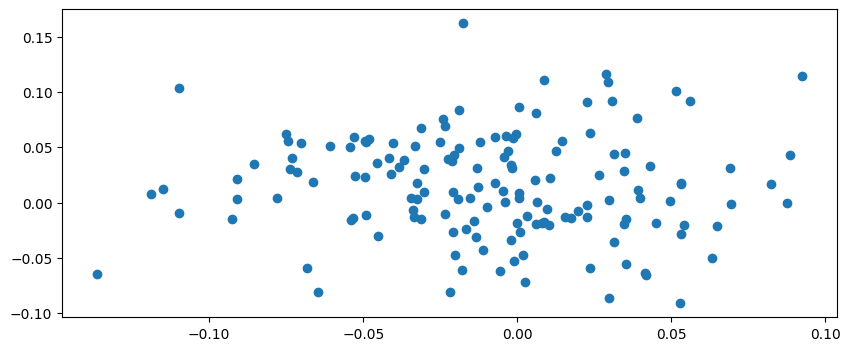

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as plt
np_question= np.array(all_questions)
plt.figure(figsize=(10,4))
plt.scatter(np_question[:,0], np_question[:,1])
plt.show()

## Cluster

## Cherche the best number of cluster

In [24]:
print(np_question)

[[-0.01273263  0.01397879 -0.06942015 ... -0.04937606  0.08106558
   0.0715189 ]
 [ 0.03153577  0.04403149 -0.01471907 ...  0.0719775  -0.03089566
   0.00697158]
 [-0.03250996  0.00321287 -0.00142659 ...  0.07501163 -0.01138252
   0.055997  ]
 ...
 [-0.01792939 -0.0610716   0.02403026 ...  0.07445704  0.00096145
  -0.08322386]
 [ 0.04508852 -0.01885323  0.01776395 ...  0.0585407  -0.05470873
  -0.02324611]
 [-0.02170321 -0.08116161  0.02916834 ... -0.03049543 -0.05125982
  -0.02902883]]


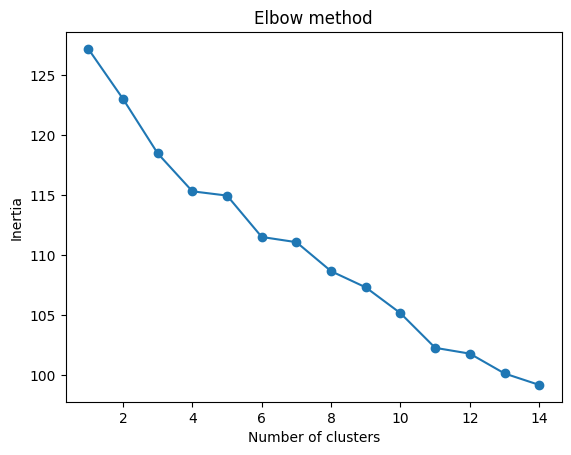

In [25]:
from sklearn.cluster import KMeans
X= np_question
inertias=[]
for i in range(1,15):
   # n_init='auto' prevents future warnings
   kmeans= KMeans(n_clusters=i, n_init='auto')
   kmeans.fit(X)
   inertias.append(kmeans.inertia_)

plt.plot(range(1,15), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Apply the pca 
To see if the  model actually works, PCA (Principal Component Analysis). PCA acts like a camera lens that rotates the data to find the angle where the clusters are most visible.

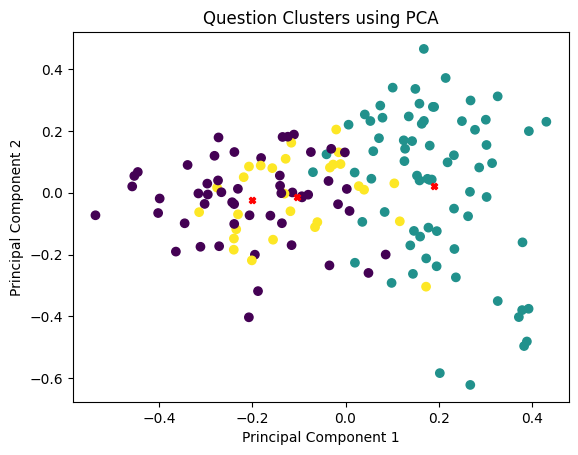

In [ ]:
from sklearn.decomposition import PCA
best_k= 3
pca= PCA(n_components=0.95)

X_pca = pca.fit_transform(X)
kmeans_model = KMeans(n_clusters=3, n_init='auto', random_state=42)
kmeans_model.fit(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_model.labels_, cmap='viridis')
centroids= kmeans_model.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, marker='X', label='Centroids')
plt.title('Question Clusters using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()